In [1]:
from util import *
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import json
from math import isclose

sns.set(font_scale=1.5)

In [2]:
df_incremental = load_incremental()[["prefix","run","iteration",
        "incremental.healthy","incremental.timeout","incremental.total[ms]","incremental.sync[ms]","incremental.prop[ms]",
        "standalone.healthy", "standalone.timeout", "standalone.total[ms]", "standalone.sync[ms]", "standalone.prop[ms]",
        "problog.exitcode",   "problog.timeout",    "problog.total[ms]",
        "storm.healthy",      "storm.timeout",      "storm.total[ms]"
]]
df_incremental['standalone.engine[ms]'] = df_incremental['standalone.total[ms]'] -(df_incremental['standalone.sync[ms]'] +df_incremental["standalone.prop[ms]"])
df_incremental['incremental.engine[ms]']= df_incremental['incremental.total[ms]']-(df_incremental['incremental.sync[ms]']+df_incremental["incremental.prop[ms]"])

## Cummulative analysis time

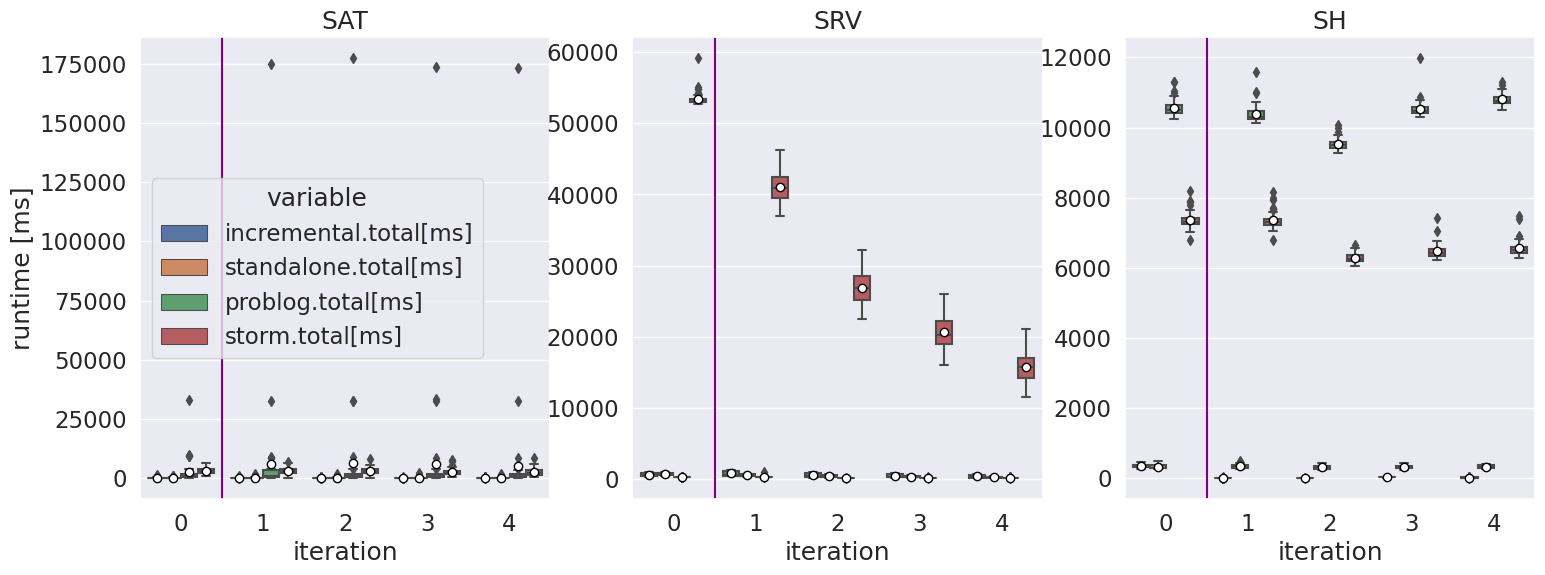

In [3]:
df = df_incremental
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=[
                 'incremental.total[ms]'
                ,'standalone.total[ms]'
                ,'problog.total[ms]'
                ,'storm.total[ms]'])
meanprops={'marker':'o',
    'markerfacecolor':'white', 
    'markeredgecolor':'black',
    'markersize':'6'}

def subplot(df, ax, case, ylabel=None, legend=False, dfx_name="iteration", dfy_name="value", hue="variable"):
    sns.boxplot(ax=ax, data=df[df['prefix']==case], x=dfx_name, y=dfy_name, hue=hue, showmeans=True, meanprops=meanprops)
    ax.set(title=case, ylabel=ylabel)
    ax.get_legend().set_visible(legend)
    ax.axvline(0.5,0,1,color='purple')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle(None)

subplot(short, axes[0], 'SAT', 'runtime [ms]', True)
subplot(short, axes[1], 'SRV', None, False)
subplot(short, axes[2], 'SH', None, False)

fig.savefig("figures/incremental_detailed.pdf", bbox_inches='tight')

Filtered entries (#18)
    prefix  run  iteration               variable        value
35     SAT    7          0  incremental.total[ms]  1340.093985
145    SAT   29          0  incremental.total[ms]   872.123602
170    SAT   34          0  incremental.total[ms]   803.287882
206    SAT   41          1  incremental.total[ms]   812.654608
224    SAT   44          4  incremental.total[ms]   705.056184
785    SAT    7          0   standalone.total[ms]  1055.747347
786    SAT    7          1   standalone.total[ms]  1780.948088
787    SAT    7          2   standalone.total[ms]   695.987041
788    SAT    7          3   standalone.total[ms]  2234.041593
789    SAT    7          4   standalone.total[ms]  1670.239271
825    SAT   15          0   standalone.total[ms]  1000.946560
922    SAT   34          2   standalone.total[ms]  1147.574033
923    SAT   34          3   standalone.total[ms]   711.731529
951    SAT   40          1   standalone.total[ms]   635.998623
956    SAT   41          1   sta

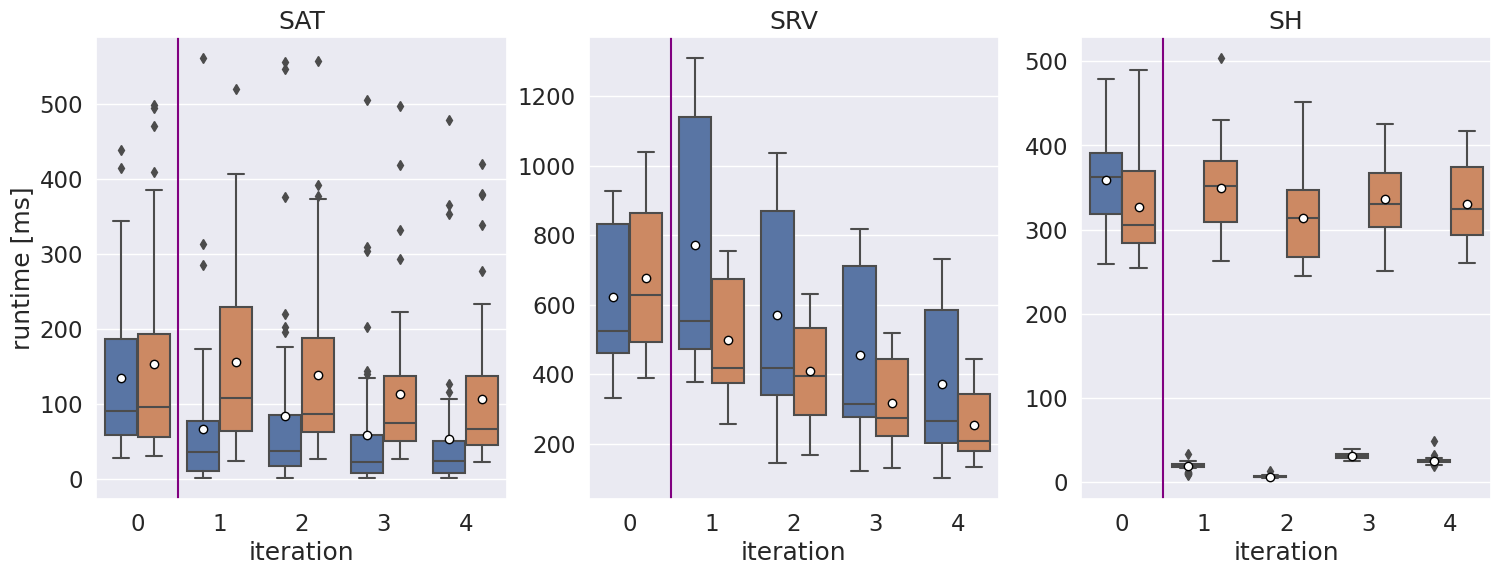

In [4]:
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=['incremental.total[ms]','standalone.total[ms]'])
meanprops={'marker':'o',
    'markerfacecolor':'white', 
    'markeredgecolor':'black',
    'markersize':'6'}


# SAT filet outlier
threshold = 600
tmp = short[short['prefix']=='SAT']
satfiltered = tmp[tmp['value'] < threshold]
discarded = tmp[tmp['value'] >= threshold]
print(f"Filtered entries (#{discarded.shape[0]})")
print(discarded)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle(None)
subplot(satfiltered, axes[0], 'SAT', 'runtime [ms]', False)
subplot(short, axes[1], 'SRV', None, False)
subplot(short, axes[2], 'SH', None, False)
fig.savefig("figures/incremental_reduced.pdf", bbox_inches='tight')



In [5]:
tmp = df_incremental.groupby(['iteration', 'prefix']).max(numeric_only=True).reset_index()[['prefix', 'iteration',
    'incremental.total[ms]'
]]
tmp.sort_values(by=['prefix', 'iteration'])

,prefix,iteration,incremental.total[ms]
0,SAT,0,1340.093985
3,SAT,1,812.654608
6,SAT,2,555.803111
9,SAT,3,504.314615
12,SAT,4,705.056184
1,SH,0,478.537785
4,SH,1,33.113202
7,SH,2,13.193083
10,SH,3,38.812461
13,SH,4,48.630101


In [6]:
df = df_incremental

tmp = df.groupby(['iteration', 'prefix']).mean(numeric_only=True).reset_index()[['prefix', 'iteration',
    'incremental.total[ms]',#'incremental.sync[ms]','incremental.prop[ms]',
    'standalone.total[ms]'#, 'standalone.sync[ms]', 'standalone.prop[ms]'
]]
tmp['Total reduction %'] = ((tmp['incremental.total[ms]'] / tmp['standalone.total[ms]'])-1)*100
tmp.sort_values(by=['prefix', 'iteration'])

,prefix,iteration,incremental.total[ms],standalone.total[ms],Total reduction %
0,SAT,0,185.949336,187.236812,-0.687619
3,SAT,1,81.447468,209.067680,-61.042535
6,SAT,2,83.262477,204.060684,-59.197198
9,SAT,3,58.192614,179.070568,-67.502971
12,SAT,4,65.339924,151.128067,-56.765196
1,SH,0,358.497804,326.263905,9.879701
4,SH,1,18.491731,349.961405,-94.716066
7,SH,2,6.198011,313.264614,-98.021477
10,SH,3,30.969072,336.336202,-90.792228
13,SH,4,25.117098,330.316779,-92.396057


## Runtime breakdown

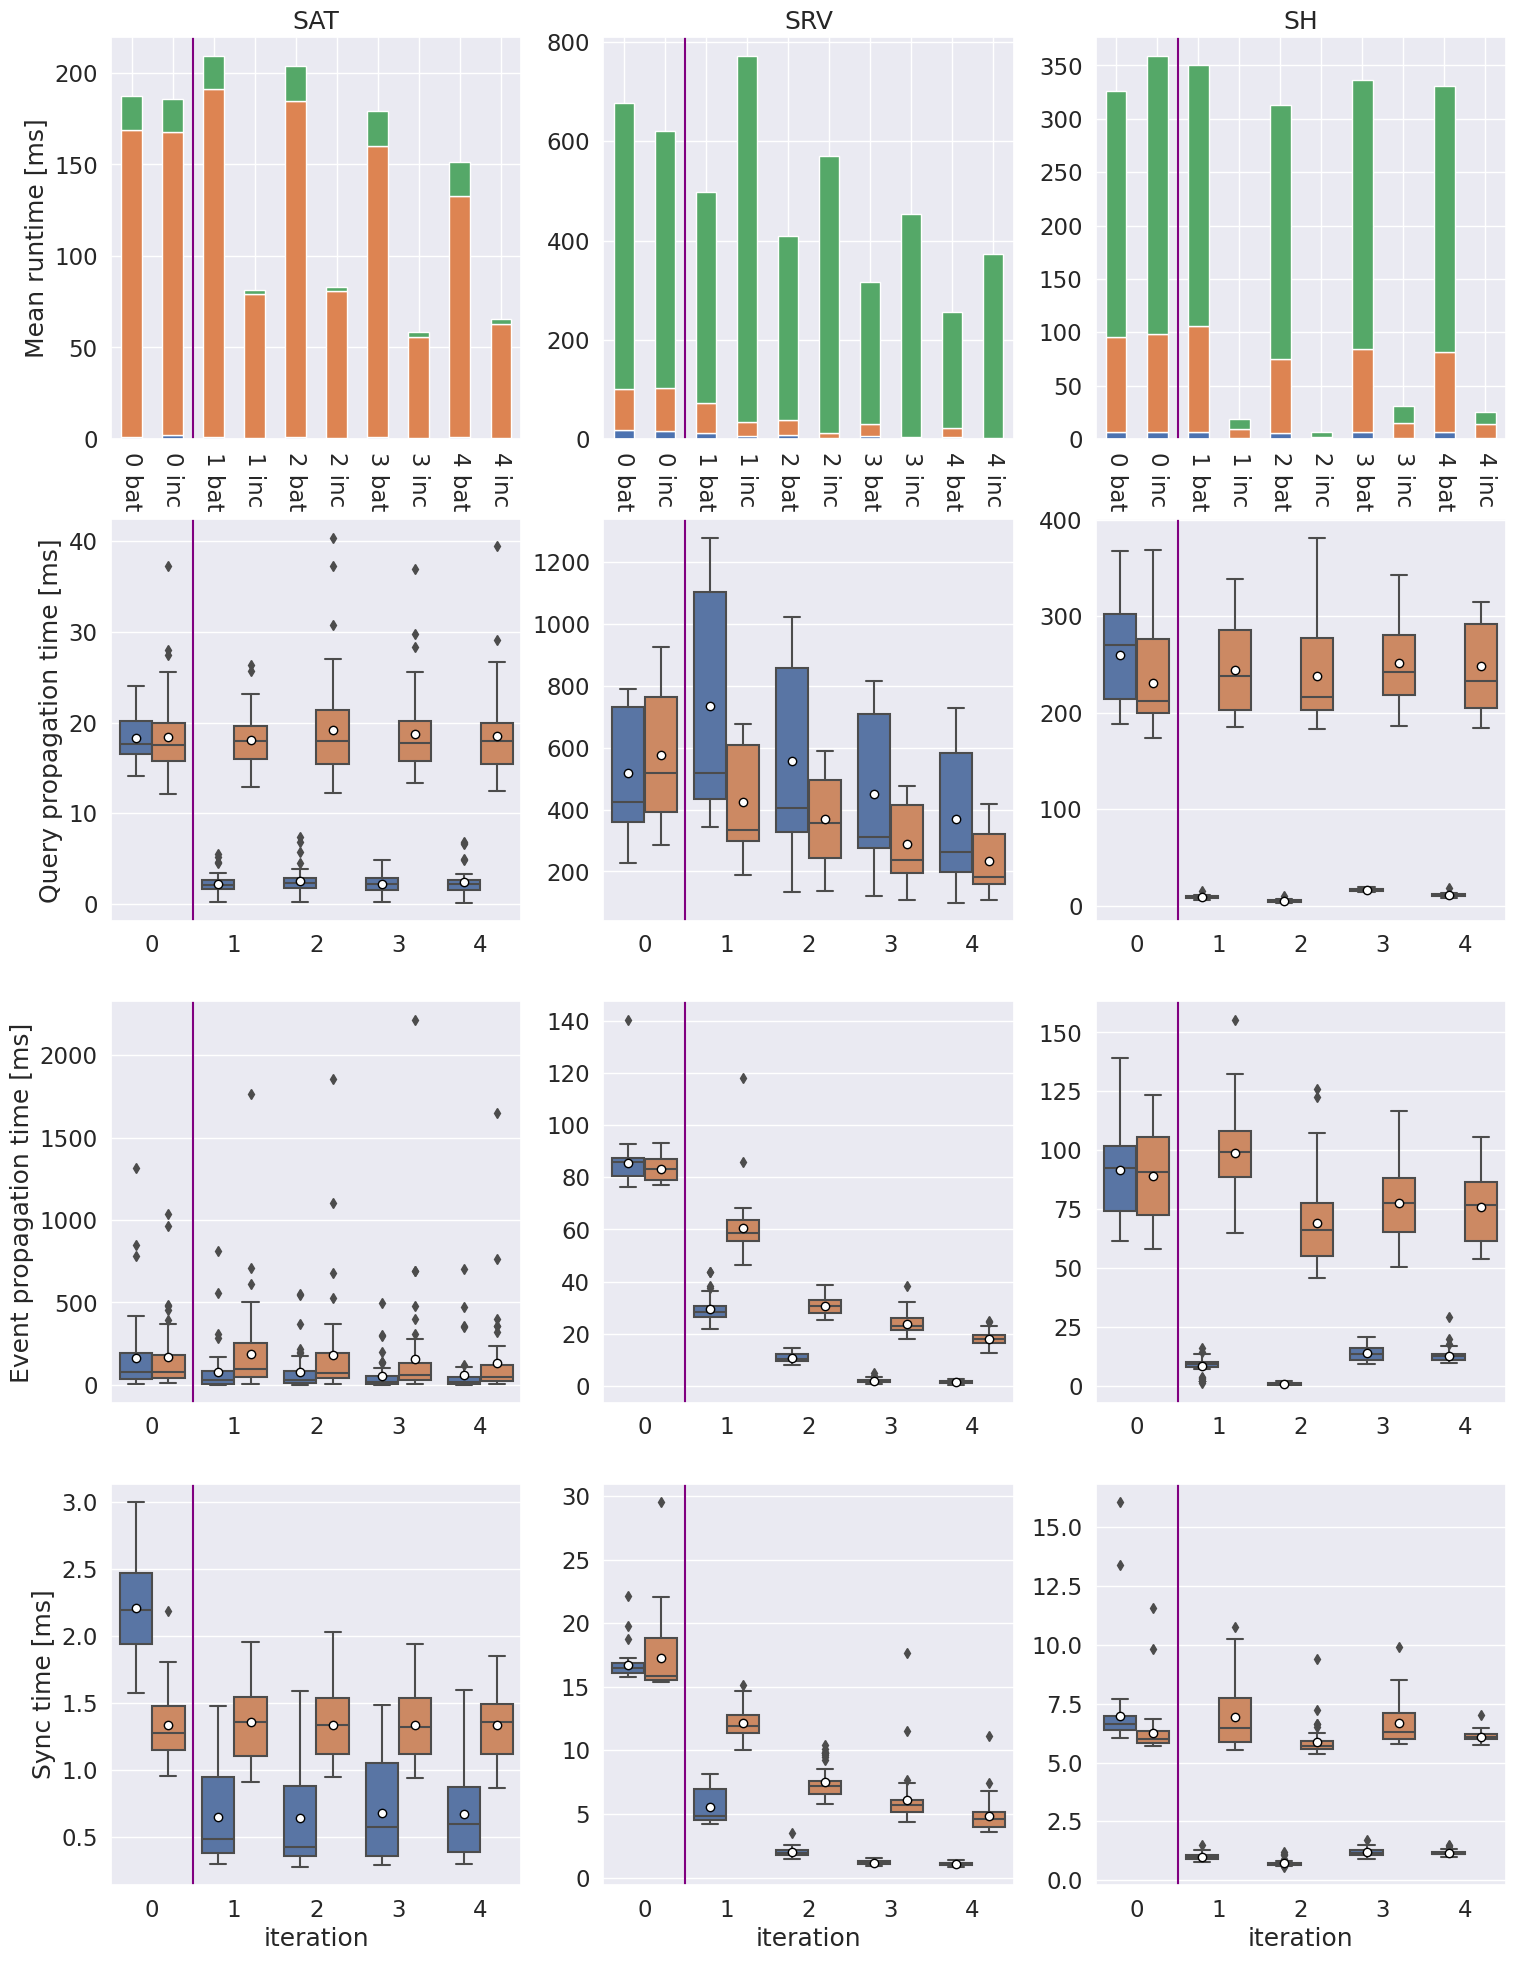

In [7]:
meanprops={'marker':'o',
    'markerfacecolor':'white', 
    'markeredgecolor':'black',
    'markersize':'6'}


def subBoxPlot(df, ax, case, ylabel=None, xlabel=None, legend=False, title=None, dfx_name="iteration", dfy_name="value", hue="variable"):
    sns.boxplot(ax=ax, data=df[df['prefix']==case], x=dfx_name, y=dfy_name, hue=hue, showmeans=True, meanprops=meanprops)
    ax.set(title=title, ylabel=ylabel, xlabel=xlabel)
    ax.get_legend().set_visible(legend)
    ax.axvline(0.5,0,1,color='purple')

def subBarChart(df, ax, case, ylabel=None, xlabel=None, legend=False, title=None, dfx_name="iteration", dfy_name=['sync[ms]','prop[ms]','engine[ms]']):
    df[df['prefix']==case].plot(kind='bar',ax=ax, x=dfx_name,y=dfy_name,stacked=True)
    ax.tick_params(axis='x', labelrotation=-90)
    ax.set(title=title, ylabel=ylabel, xlabel=xlabel)
    ax.get_legend().set_visible(legend)
    ax.axvline(1.5,0,1,color='purple')
    
fig, axes = plt.subplots(4, 3, figsize=(18,24))
fig.suptitle(None)

df.groupby(['prefix', 'iteration']).median()

# Mean relative breakdown
short=df.groupby(['prefix', 'iteration']).aggregate('mean').reset_index()
short_inc = pd.melt(df, id_vars=['prefix','iteration'],
           value_vars=['incremental.engine[ms]','incremental.sync[ms]','incremental.prop[ms]'])
short_inc['type']='inc'
short_sa = pd.melt(df, id_vars=['prefix','iteration'],
            value_vars=['standalone.engine[ms]','standalone.sync[ms]','standalone.prop[ms]'])
short_sa['type']='bat'

short = pd.concat([short_sa,short_inc],ignore_index=True)
short['variable']=short['variable'].map({
                 'incremental.engine[ms]':'engine[ms]',
                 'incremental.sync[ms]':'sync[ms]',
                 'incremental.prop[ms]':'prop[ms]',
                 'standalone.engine[ms]':'engine[ms]',
                 'standalone.sync[ms]':'sync[ms]',
                 'standalone.prop[ms]':'prop[ms]'
})
short = short.pivot_table(index=['prefix','iteration','type'], columns='variable')['value'].reset_index()
short['iteration'] = short['iteration'].astype(str)+' '+short['type']

subBarChart(short, axes[0,0], 'SAT', title='SAT', ylabel='Mean runtime [ms]')
subBarChart(short, axes[0,1], 'SRV', title='SRV')
subBarChart(short, axes[0,2], 'SH', title='SH')

# Query propagation
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=['incremental.engine[ms]','standalone.engine[ms]'])
subBoxPlot(short, axes[1,0], 'SAT', ylabel='Query propagation time [ms]')
subBoxPlot(short, axes[1,1], 'SRV')
subBoxPlot(short, axes[1,2], 'SH')

# Event propagation time
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=['incremental.prop[ms]','standalone.prop[ms]'])
subBoxPlot(short, axes[2,0], 'SAT', ylabel='Event propagation time [ms]')
subBoxPlot(short, axes[2,1], 'SRV')
subBoxPlot(short, axes[2,2], 'SH')

#Sync time
short = pd.melt(df, id_vars=['prefix','run','iteration'],
            value_vars=['incremental.sync[ms]','standalone.sync[ms]'])
subBoxPlot(short, axes[3,0], 'SAT', xlabel='iteration', ylabel='Sync time [ms]')
subBoxPlot(short, axes[3,1], 'SRV', xlabel='iteration')
subBoxPlot(short, axes[3,2], 'SH', xlabel='iteration')



fig.savefig("figures/eval-all.pdf", bbox_inches='tight')

In [8]:
# Mean subtask times
df = df_incremental

tmp = df.groupby(['iteration', 'prefix']).mean(numeric_only=True).reset_index()[['prefix', 'iteration',
    'incremental.total[ms]', 'incremental.engine[ms]', 'incremental.sync[ms]','incremental.prop[ms]',
    'standalone.total[ms]', 'standalone.engine[ms]', 'standalone.sync[ms]', 'standalone.prop[ms]'
]]
tmp['Total reduction %'] = ((tmp['incremental.total[ms]'] / tmp['standalone.total[ms]'])-1)*100
tmp['Engine reduction %'] = ((tmp['incremental.engine[ms]'] / tmp['standalone.engine[ms]'])-1)*100
tmp['Sync reduction %'] = ((tmp['incremental.sync[ms]'] / tmp['standalone.sync[ms]'])-1)*100
tmp['Prop reduction %'] = ((tmp['incremental.prop[ms]'] / tmp['standalone.prop[ms]'])-1)*100
tmp.sort_values(by=['prefix', 'iteration'])#[['prefix', 'iteration','Total reduction %']]

,prefix,iteration,incremental.total[ms],incremental.engine[ms],incremental.sync[ms],incremental.prop[ms],standalone.total[ms],standalone.engine[ms],standalone.sync[ms],standalone.prop[ms],Total reduction %,Engine reduction %,Sync reduction %,Prop reduction %
0,SAT,0,185.949336,18.264371,2.208070,165.476895,187.236812,18.377212,1.338606,167.520994,-0.687619,-0.614029,64.953021,-1.220205
3,SAT,1,81.447468,2.264798,0.650196,78.532474,209.067680,18.035490,1.355229,189.676961,-61.042535,-87.442551,-52.023132,-58.596725
6,SAT,2,83.262477,2.530720,0.641334,80.090423,204.060684,19.143892,1.338964,183.577828,-59.197198,-86.780536,-52.102218,-56.372497
9,SAT,3,58.192614,2.192778,0.680290,55.319546,179.070568,18.785055,1.338374,158.947138,-67.502971,-88.327006,-49.170441,-65.196262
12,SAT,4,65.339924,2.408472,0.668686,62.262766,151.128067,18.549738,1.334940,131.243389,-56.765196,-87.016142,-49.908855,-52.559313
1,SH,0,358.497804,260.055871,6.995632,91.446302,326.263905,230.814606,6.264840,89.184459,9.879701,12.668724,11.664978,2.536140
4,SH,1,18.491731,8.861821,0.996587,8.633323,349.961405,244.133453,6.926542,98.901410,-94.716066,-96.370091,-85.612057,-91.270779
7,SH,2,6.198011,4.564275,0.727587,0.906149,313.264614,238.385067,5.861246,69.018301,-98.021477,-98.085335,-87.586476,-98.687088
10,SH,3,30.969072,15.988051,1.183415,13.797606,336.336202,251.968098,6.703064,77.665040,-90.792228,-93.654732,-82.345156,-82.234470
13,SH,4,25.117098,11.018152,1.161173,12.937774,330.316779,248.358005,6.104456,75.854319,-92.396057,-95.563601,-80.978279,-82.943920


## Appendix data

### Total incremental runtime (Code id: DP.I.1)

In [9]:
df = df_incremental

df = df.groupby(['prefix','iteration']).agg('mean')
df = df[['incremental.total[ms]','standalone.total[ms]']].reset_index()
print
for it in range(0,5):
    print(f"\t\t{it} ", end="")
    idata = df[df['iteration']==it]
    for domain in ['SAT','SRV','SH']:
        dfdomain = idata[idata['prefix']==domain]
        print(f" & {dfdomain['incremental.total[ms]'].mean():.2f} & {dfdomain['standalone.total[ms]'].mean():.2f}", end="")
    print(' \\\\')
    print("\t\\hline")


		0  & 185.95 & 187.24 & 621.46 & 676.39 & 358.50 & 326.26 \\
	\hline
		1  & 81.45 & 209.07 & 771.17 & 498.15 & 18.49 & 349.96 \\
	\hline
		2  & 83.26 & 204.06 & 570.46 & 409.10 & 6.20 & 313.26 \\
	\hline
		3  & 58.19 & 179.07 & 454.17 & 317.14 & 30.97 & 336.34 \\
	\hline
		4  & 65.34 & 151.13 & 372.32 & 255.36 & 25.12 & 330.32 \\
	\hline


### Query propagation runtime (Code id: DP.IQ.1)

In [10]:
df = df_incremental

df = df.groupby(['prefix','iteration']).agg('mean')
df = df[['incremental.engine[ms]','standalone.engine[ms]']].reset_index()
print
for it in range(0,5):
    print(f"\t\t{it} ", end="")
    idata = df[df['iteration']==it]
    for domain in ['SAT','SRV','SH']:
        dfdomain = idata[idata['prefix']==domain]
        print(f" & {dfdomain['incremental.engine[ms]'].mean():.2f} & {dfdomain['standalone.engine[ms]'].mean():.2f}", end="")
    print(' \\\\')
    print("\t\\hline")

		0  & 18.26 & 18.38 & 519.07 & 576.05 & 260.06 & 230.81 \\
	\hline
		1  & 2.26 & 18.04 & 736.29 & 425.33 & 8.86 & 244.13 \\
	\hline
		2  & 2.53 & 19.14 & 557.68 & 370.82 & 4.56 & 238.39 \\
	\hline
		3  & 2.19 & 18.79 & 451.05 & 287.32 & 15.99 & 251.97 \\
	\hline
		4  & 2.41 & 18.55 & 369.77 & 232.48 & 11.02 & 248.36 \\
	\hline


### Event propagation runtime (Code id: DP.IE.1)

In [11]:
df = df_incremental

df = df.groupby(['prefix','iteration']).agg('mean')
df = df[['incremental.prop[ms]','standalone.prop[ms]']].reset_index()
print
for it in range(0,5):
    print(f"\t\t{it} ", end="")
    idata = df[df['iteration']==it]
    for domain in ['SAT','SRV','SH']:
        dfdomain = idata[idata['prefix']==domain]
        print(f" & {dfdomain['incremental.prop[ms]'].mean():.2f} & {dfdomain['standalone.prop[ms]'].mean():.2f}", end="")
    print(' \\\\')
    print("\t\\hline")

		0  & 165.48 & 167.52 & 85.71 & 83.06 & 91.45 & 89.18 \\
	\hline
		1  & 78.53 & 189.68 & 29.33 & 60.68 & 8.63 & 98.90 \\
	\hline
		2  & 80.09 & 183.58 & 10.78 & 30.80 & 0.91 & 69.02 \\
	\hline
		3  & 55.32 & 158.95 & 1.95 & 23.75 & 13.80 & 77.67 \\
	\hline
		4  & 62.26 & 131.24 & 1.48 & 18.06 & 12.94 & 75.85 \\
	\hline


### Sync runtime (Code id: DP.IS.1)

In [12]:
df = df_incremental

df = df.groupby(['prefix','iteration']).agg('mean')
df = df[['incremental.sync[ms]','standalone.sync[ms]']].reset_index()
print
for it in range(0,5):
    print(f"\t\t{it} ", end="")
    idata = df[df['iteration']==it]
    for domain in ['SAT','SRV','SH']:
        dfdomain = idata[idata['prefix']==domain]
        print(f" & {dfdomain['incremental.sync[ms]'].mean():.2f} & {dfdomain['standalone.sync[ms]'].mean():.2f}", end="")
    print(' \\\\')
    print("\t\\hline")

		0  & 2.21 & 1.34 & 16.68 & 17.29 & 7.00 & 6.26 \\
	\hline
		1  & 0.65 & 1.36 & 5.55 & 12.14 & 1.00 & 6.93 \\
	\hline
		2  & 0.64 & 1.34 & 2.01 & 7.48 & 0.73 & 5.86 \\
	\hline
		3  & 0.68 & 1.34 & 1.18 & 6.08 & 1.18 & 6.70 \\
	\hline
		4  & 0.67 & 1.33 & 1.08 & 4.82 & 1.16 & 6.10 \\
	\hline


# Legacy code

In [13]:
df = df_incremental

df = df.groupby(['prefix','iteration']).agg('mean').reset_index()
for tool in ['incremental','standalone']:
    for task in ['engine','sync','prop']:
        df[f'{tool}.{task} %'] = (df[f'{tool}.{task}[ms]']/df[f'{tool}.total[ms]'])*100
df[['prefix','iteration','incremental.engine %','incremental.prop %','incremental.sync %','standalone.engine %','standalone.prop %','standalone.sync %']]

,prefix,iteration,incremental.engine %,incremental.prop %,incremental.sync %,standalone.engine %,standalone.prop %,standalone.sync %
0,SAT,0,9.822229,88.990312,1.187458,9.814957,89.470117,0.714927
1,SAT,1,2.780685,96.421014,0.798301,8.626628,90.725148,0.648225
2,SAT,2,3.039448,96.190296,0.770256,9.381470,89.962370,0.656160
3,SAT,3,3.768139,95.062830,1.169031,10.490309,88.762291,0.747400
4,SAT,4,3.686064,95.290539,1.023396,12.274185,86.842498,0.883317
5,SH,0,72.540436,25.508190,1.951374,70.744757,27.335068,1.920176
6,SH,1,47.923157,46.687477,5.389365,69.760108,28.260662,1.979230
7,SH,2,73.640956,14.620001,11.739044,76.097030,22.031949,1.871021
8,SH,3,51.625863,44.552855,3.821282,74.915545,23.091490,1.992965
9,SH,4,43.867138,51.509825,4.623036,75.187826,22.964113,1.848061


In [14]:
short=df.groupby(['prefix', 'iteration']).aggregate('mean').reset_index()
#short_inc = pd.melt(df, id_vars=['prefix','iteration'],
#            value_vars=['incremental.engine[ms]','incremental.sync[ms]','incremental.prop[ms]'],
#            var_name='inc-var', value_name='inc-val')
#short_sa = pd.melt(df, id_vars=['prefix','iteration'],
#            value_vars=['standalone.engine[ms]','standalone.sync[ms]','standalone.prop[ms]'],
#            var_name='std-var', value_name='std-val')

short_inc = pd.melt(df, id_vars=['prefix','iteration'],
           value_vars=['incremental.engine[ms]','incremental.sync[ms]','incremental.prop[ms]'])
short_inc['type']='inc'
short_sa = pd.melt(df, id_vars=['prefix','iteration'],
            value_vars=['standalone.engine[ms]','standalone.sync[ms]','standalone.prop[ms]'])
short_sa['type']='bat'

short = pd.concat([short_sa,short_inc],ignore_index=True)
short['variable']=short['variable'].map({'incremental.engine[ms]':'engine[ms]',
                 'incremental.sync[ms]':'sync[ms]',
                 'incremental.prop[ms]':'prop[ms]',
                 'standalone.engine[ms]':'engine[ms]',
                 'standalone.sync[ms]':'sync[ms]',
                 'standalone.prop[ms]':'prop[ms]'})
short = short.pivot_table(index=['prefix','iteration','type'], columns='variable')['value'].reset_index()
short['iteration'] = short['iteration'].astype(str)+' '+short['type']

In [15]:
print('SAT - inc')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SAT')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SAT')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SAT')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')
print('SAT - batch')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SAT')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SAT')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SAT')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')

print('SRV - inc')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SRV')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SRV')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SRV')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')
print('SRV - batch')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SRV')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SRV')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SRV')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')

print('SH - inc')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SH')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SH')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} inc") & (short['prefix']=='SH')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')
print('SH - batch')
for i in range(0,5):
    satIQ=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SH')]['engine[ms]'].values[0]
    satIE=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SH')]['prop[ms]'].values[0]
    satIS=short[(short['iteration']==f"{i} bat") & (short['prefix']=='SH')]['sync[ms]'].values[0]
    ssum=satIS+satIE+satIQ
    print(f'{i} - Query: {satIQ/ssum:.2%}; Event: {satIE/ssum:.2%}; Synt: {satIS/ssum:.2%}')


SAT - inc
0 - Query: 9.82%; Event: 88.99%; Synt: 1.19%
1 - Query: 2.78%; Event: 96.42%; Synt: 0.80%
2 - Query: 3.04%; Event: 96.19%; Synt: 0.77%
3 - Query: 3.77%; Event: 95.06%; Synt: 1.17%
4 - Query: 3.69%; Event: 95.29%; Synt: 1.02%
SAT - batch
0 - Query: 9.81%; Event: 89.47%; Synt: 0.71%
1 - Query: 8.63%; Event: 90.73%; Synt: 0.65%
2 - Query: 9.38%; Event: 89.96%; Synt: 0.66%
3 - Query: 10.49%; Event: 88.76%; Synt: 0.75%
4 - Query: 12.27%; Event: 86.84%; Synt: 0.88%
SRV - inc
0 - Query: 83.52%; Event: 13.79%; Synt: 2.68%
1 - Query: 95.48%; Event: 3.80%; Synt: 0.72%
2 - Query: 97.76%; Event: 1.89%; Synt: 0.35%
3 - Query: 99.31%; Event: 0.43%; Synt: 0.26%
4 - Query: 99.31%; Event: 0.40%; Synt: 0.29%
SRV - batch
0 - Query: 85.16%; Event: 12.28%; Synt: 2.56%
1 - Query: 85.38%; Event: 12.18%; Synt: 2.44%
2 - Query: 90.64%; Event: 7.53%; Synt: 1.83%
3 - Query: 90.59%; Event: 7.49%; Synt: 1.92%
4 - Query: 91.04%; Event: 7.07%; Synt: 1.89%
SH - inc
0 - Query: 72.54%; Event: 25.51%; Synt: 1.